In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [2]:
from pathlib import Path
import sys
from collections import OrderedDict, defaultdict
import math

import compress_pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd


def sublistinlist(sublist, test_list):
    return any(test_list[idx : idx + len(sublist)] == sublist
               for idx in range(len(test_list) - len(sublist) + 1))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:264: DeprecationWarning: 'U' mode is deprecated


In [3]:
df_path = Path('all_reduced.pkl.gz')
df = None
if df_path.exists():
    print('imported data from cache', df_path)
    try:
        df = pd.read_pickle(df_path)
    except:
        print(sys.exc_info()[2])
if df is None:
    raw_dataframes = Path('.').glob('**/dataframe.p*')
    for p in raw_dataframes:
        print(p)
        d = compress_pickle.load(p)
        d.drop(columns=['kc_results', 'raw output'], inplace=True)
        # Removed estimated ECM multi-core
        d['ecm_multicore_estimate'] = d.apply(lambda r: r.pmodel == 'ECM' and r.cores != 1 and  
                                                        (not sublistinlist(['-c', str(r.cores)], r.job.arguments)),
                                              axis=1)
        d.drop(index=d[d.ecm_multicore_estimate].index, inplace=True)
        df = pd.concat([df, d], copy=False)
        del d
    print('imported data from raw dataframes', raw_dataframes)
    df.to_pickle(df_path)
    print("saved data to cache", df_path)

imported data from cache all_reduced.pkl.gz


In [4]:
df['host'] = df.job.map(lambda j: j.workload.host.name)
df['kernel'] = df.job.map(lambda j: j.workload.kernel.parameter.replace('.c', '').replace('/constant/homogeneous/double', '').replace('/', '-'))

df.drop_duplicates(['pmodel', 'host', 'kernel', 'compiler', 'define', 'cores', 'incore_model', 'cache_predictor'])
df.reset_index(inplace=True)
del df['index']
df = df[df.ecm_multicore_estimate == False]

In [5]:
config = OrderedDict([
    ('skylakesp2', {'arch': 'SKX',
                   'cache_predictor': 'LC',
                   'incore_model': 'IACA'}),
    ('ivyep1', {'arch': 'IVB',
               'cache_predictor': 'SIM',
               'incore_model': 'IACA'}),
    ('naples1', {'arch': 'ZEN',
                'cache_predictor': 'SIM',
                'incore_model': 'OSACA'}),
    ('rome1', {'arch': 'ZEN2',
              'cache_predictor': 'SIM',
              'incore_model': 'OSACA'}),
    ('warmup', {'arch': 'TX2',
               'cache_predictor': 'SIM',
               'incore_model': 'OSACA'}),
    ('qpace4', {'arch': 'A64FX',
               'cache_predictor': 'SIM',
               'incore_model': 'OSACA'})
])
archs = {config[h]['arch']: config[h] for h in config}

kernelname_map = {
    "2D-r1-star": "2d-5pt",
    "3D-r1-star": "3d-7pt",
    "3D-r1-box": "3d-27pt",
    "3D-r3-star": "3d-r3-19pt",
    "3D-r3-box": "3d-r3-343pt"
}
kernelname_map_r = {v: k for k,v in kernelname_map.items()}

In [6]:
analysis_path = Path('analysis.pkl.gz')
analysis = None
if analysis_path.exists():
    print("imported analysis from cache", analysis_path)
    try:
        analysis = pd.read_pickle(analysis_path)
    except:
        print(sys.exc_info()[2])
if analysis is None:
    analysis = []
    for h in df.host.unique():
        cp = config[h]['cache_predictor']
        icm = config[h]['incore_model']
        print(h, cp, icm)
        for k in df.kernel.unique():
            print(" "*len(h), k, end=": ", flush=True)
            rows_hk = df.query("host == @h and kernel == @k")
            for cpl in rows_hk.compiler.dropna().unique():
                print(cpl, end=" ", flush=True)
                for d in rows_hk.define.dropna().unique():
                    # Single core
                    c = 1
                    #print(h, k, cpl, d, c)
                    rows = rows_hk.query("define == @d and cores == @c and compiler == @cpl")
                    ecm = rows.query("pmodel == 'ECM' and cache_predictor == @cp and incore_model == @icm")['performance [cy/CL]']
                    rl = rows.query("pmodel == 'RooflineIACA' and cache_predictor == @cp and incore_model == @icm")['performance [cy/CL]']
                    bench = rows.query("pmodel == 'Benchmark'")['performance [cy/CL]']
                    iterations_per_cacheline = rows['iterations per cacheline']
                    a = {
                        'arch': config[h]['arch'],
                        'host': h,
                        'kernel': k,
                        'compiler': cpl,
                        'define': d,
                        'multicore': False,
                        'cores': 1,
                        'prediction_ECM': None if ecm.empty else ecm.iloc[0],
                        'prediction_RL': None if rl.empty else rl.iloc[0],
                        'measured': None if bench.empty else bench.iloc[0],
                        'iterations_per_cacheline': None if iterations_per_cacheline.empty else iterations_per_cacheline.iloc[0],
                    }

                    analysis.append(a)


                for c in range(2, rows_hk[rows_hk.define == rows_hk.define.max()].cores.max()+1):
                    #print(h, k, cpl, d, c)
                    rows = rows_hk.query("define == @d and cores == @c and compiler == @cpl")
                    ecm = rows.query("pmodel == 'ECM' and cache_predictor == @cp and incore_model == @icm")['performance [cy/CL]']
                    rl = rows.query("pmodel == 'RooflineIACA' and cache_predictor == @cp and incore_model == @icm")['performance [cy/CL]']
                    bench = rows.query("pmodel == 'Benchmark'")['performance [cy/CL]']
                    iterations_per_cacheline = rows['iterations per cacheline']
                    a = {
                        'arch': config[h]['arch'],
                        'host': h,
                        'kernel': k,
                        'compiler': cpl,
                        'define': rows_hk.define.max(),
                        'multicore': True,
                        'cores': c,
                        'prediction_ECM': None if ecm.empty else ecm.iloc[0],
                        'prediction_RL': None if rl.empty else rl.iloc[0],
                        'measured': None if bench.empty else bench.iloc[0],
                        'iterations_per_cacheline': None if iterations_per_cacheline.empty else iterations_per_cacheline.iloc[0],
                    }

                    analysis.append(a)
            print()
    print("imported analysis from raw data")
    analysis = pd.DataFrame(analysis)
    analysis['relative_error_ECM'] = (analysis['measured'] - analysis['prediction_ECM']) / analysis['measured']
    analysis['relative_error_RL'] = (analysis['measured'] - analysis['prediction_RL']) / analysis['measured']
    analysis.to_pickle(analysis_path)
    print("saved analysis to cache", analysis_path)
if 'max_define' in analysis.columns:
    analysis['multicore'] = analysis['max_define']
    del analysis['max_define']
analysis_idx = analysis.set_index(['arch', 'kernel', 'compiler', 'define', 'cores'], drop=False, verify_integrity=True)

imported analysis from cache analysis.pkl.gz


## Overview of All Observed Accuracies

The overall distribution of relative errors for single-core ECM predictions shows a strong tendency towards the 0 to +10% interval:

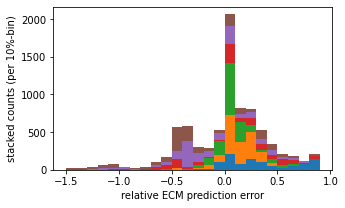

In [7]:
ax = analysis[analysis.cores==1].pivot(columns='arch').relative_error_ECM.plot(
    kind='hist',
    bins=np.arange(-1.5, 1.0, 0.1),
    stacked=True,
    legend=False,
    figsize=(5,3))

ax.set_xlabel('relative ECM prediction error')
ax.set_ylabel('stacked counts (per 10%-bin)')
ax.figure.savefig("errhist_single-core.pdf", bbox_inches='tight')

Looking at multi-core predictions and measurements, the overall accuracy is even better. This is likely due to the better accuracy of saturated data bottlenecks rather than single-core bottlenecks in unsaturated datapaths:

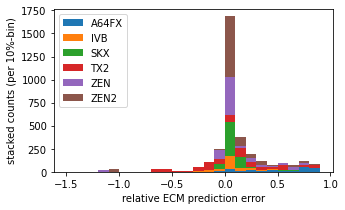

In [8]:
ax = analysis[analysis.multicore == True].pivot(columns='arch').relative_error_ECM.plot(
    kind='hist',
    bins=np.arange(-1.5, 1.0, 0.1),
    stacked=True,
    figsize=(5,3))

ax.set_xlabel('relative ECM prediction error')
ax.set_ylabel('stacked counts (per 10%-bin)')
ax.legend(loc='upper left')
ax.figure.savefig("errhist_multi-core.pdf", bbox_inches='tight')

## Single-Core Accuracies

In [9]:
relerrcolors = {
    'green': (174/255, 213/255, 166/255, 1),
    'yellow': (255/255, 254/255, 187/255, 1),
    'orange': (251/255, 220/255, 177/255, 1),
    'red': (255/255, 173/255, 167/255, 1)
}
def single_core_plots(cases, arrangement, legend=None, filename=None):
    assert len(cases) <= arrangement[0]*arrangement[1], \
        "More cases than spots in arrangement"
    fig, axs = plt.subplots(arrangement[1], arrangement[0],
                            figsize=(3*arrangement[0]+1, 1.6*arrangement[1]+1),
                            squeeze=False)
    
    xi, yi = -1, 0
    for kernel, arch, compiler in cases:
        kernel_orig = kernelname_map_r.get(kernel, kernel)
        xi += 1
        if xi >= arrangement[0]:
            yi += 1
            xi = 0
        ax = axs[yi,xi]
        
        d = analysis.query(
            "arch == @arch and kernel == @kernel_orig and compiler == @compiler and cores == 1"
        ).sort_values('define')
        
        d.plot(
            x='define',
            y=['measured', 'prediction_ECM'],
            ax=ax,
            style=['+', '_'],
            color=['black', 'blue'],
            grid=True,
            legend=False,
            logx=True)
        ax.set_ylim(bottom=0)
        
        if len(d) == 0:
            continue
        start = d.define.min()*(1-1/len(d))
        cur_region = None
        for idx, row in d.iterrows():
            if np.isnan(row.relative_error_ECM):
                new_region = None
            elif abs(row.relative_error_ECM) < 0.1:
                new_region = relerrcolors['green']
            elif abs(row.relative_error_ECM) < 0.2:
                new_region = relerrcolors['yellow']
            elif abs(row.relative_error_ECM) < 0.5:
                new_region = relerrcolors['orange']
            else:
                new_region = relerrcolors['red']
            if cur_region != new_region:
                new_start = row.define*(1-1/len(d))
                if cur_region is not None:
                    ax.axvspan(
                        start, new_start,
                        facecolor=cur_region)
                start = new_start
                cur_region = new_region
        if cur_region is not None:
            ax.axvspan(
                start, row.define*(1+1/len(d)),
                facecolor=cur_region)

        ax.set_title("{} with {} on {}".format(kernel, compiler, arch))
        ax.set_xlabel("dimension length (N)")
        ax.set_ylabel("cycle per {:.0f} It.".format(d.iterations_per_cacheline.iloc[0]))
    
    if legend is not None:
        filler = []
        if legend.get('ncol', 1) == 2:
            filler = [plt.Rectangle((0,0), 0,0, alpha=0)]*2
        fig.legend(axs[0,0].lines + filler + [
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['green']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['yellow']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['orange']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['red'])],
                   ['ECM prediction', 'measured'] + ['' for f in filler] + [
                    '|rel. error ECM| < 10%',
                    '|rel. error ECM| < 20%',
                    '|rel. error ECM| < 50%',
                    '|rel. error ECM| ≥ 50%'],
                   **legend)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

Well predicted examples:

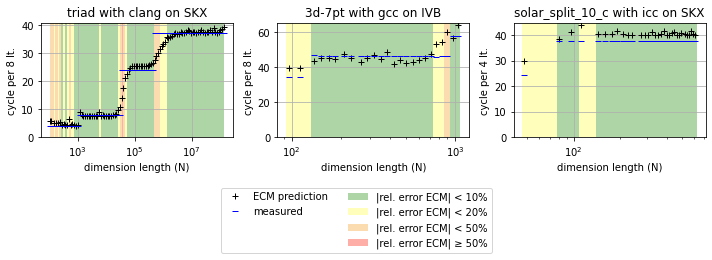

In [10]:
single_core_plots([('triad', 'SKX', 'clang'),
                   ('3d-7pt', 'IVB', 'gcc'),
                   ('solar_split_10_c', 'SKX', 'icc')],
                  arrangement=(3, 1),
                  legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.4), 'ncol': 2},
                  filename='single_core_good.pdf')

### Warmup
The first plot is a a well predicted warmup phase and the second shows large overheads, which are not well predicted:

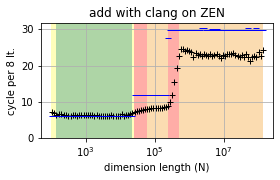

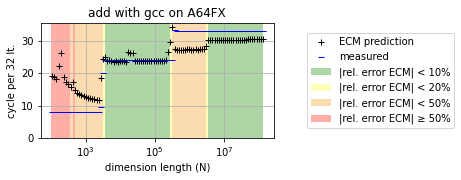

In [11]:
single_core_plots([('add', 'ZEN', 'clang')],
                  arrangement=(1, 1),
                  legend=None,
                  filename='single_core_warmup_good.pdf')
single_core_plots([('add', 'A64FX', 'gcc')],
                  arrangement=(1, 1),
                  legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                  filename='single_core_warmup_bad.pdf')

### Execution Bound Predictions
The first three plots are execution bound and well predicted, while the last two are also (in part) execution bound, but not accuratly predicted:

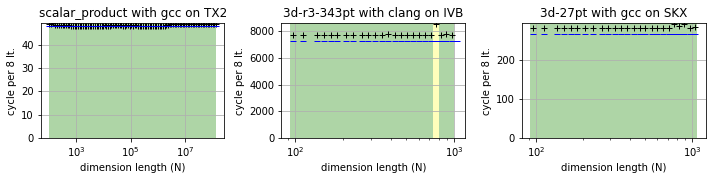

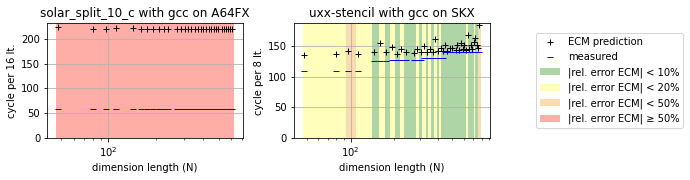

In [12]:
single_core_plots([('scalar_product', 'TX2', 'gcc'),
                   ('3d-r3-343pt', 'IVB', 'clang'),
                   ('3d-27pt', 'SKX', 'gcc')],
                  arrangement=(3, 1),
                  legend=None,
                  filename='single_core_exec_good.pdf')
single_core_plots([('solar_split_10_c', 'A64FX', 'gcc'),
                   ('uxx-stencil', 'SKX', 'gcc')],
                  arrangement=(2, 1),
                  legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                  filename='single_core_exec_bad.pdf')

### Data Bound Predictions
In the first plot, changes in the data pattern are well predicted, while in the following three plots changes are not very accuratly predicted:

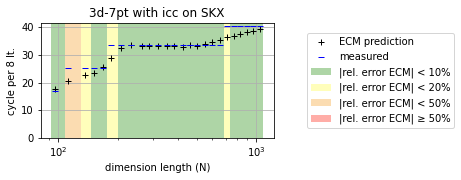

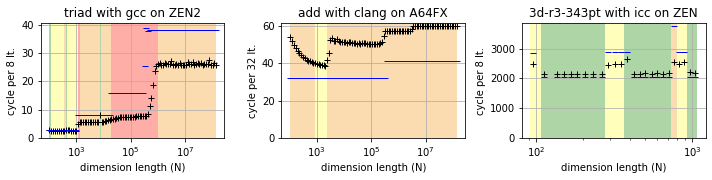

In [13]:
single_core_plots([('3d-7pt', 'SKX', 'icc')],
                  arrangement=(1, 1),
                  legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                  filename='single_core_data_good.pdf')
single_core_plots([('triad', 'ZEN2', 'gcc'),
                   ('add', 'A64FX', 'clang'),
                   ('3d-r3-343pt', 'ZEN', 'icc')],
                  arrangement=(3, 1),
                  legend=None,
                  filename='single_core_data_bad.pdf')

### Thrashing Effects
Thrashing effects often show as regular up-down patterns, which are sometime reasonably well predicted (first two plots), but not always (last two):

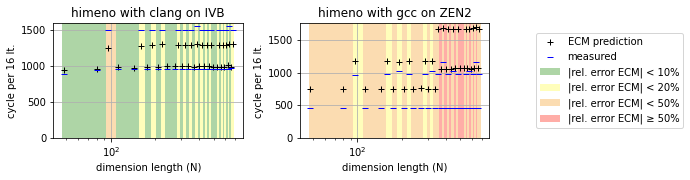

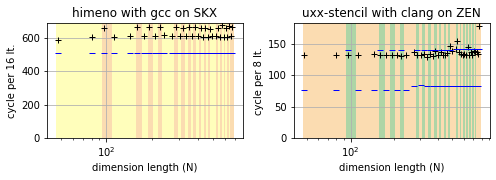

In [14]:
single_core_plots([('himeno', 'IVB', 'clang'),
                   ('himeno', 'ZEN2', 'gcc')],
                  arrangement=(2, 1),
                  legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                  filename='single_core_thrashing_good.pdf')
single_core_plots([('himeno', 'SKX', 'gcc'),
                   ('uxx-stencil', 'ZEN', 'clang')],
                  arrangement=(2, 1),
                  legend=None,
                  filename='single_core_thrashing_bad.pdf')

### Complete Single-Core Analysis

In [15]:
relerrcolors = {
    'green': (174/255, 213/255, 166/255, 1),
    'yellow': (255/255, 254/255, 187/255, 1),
    'orange': (251/255, 220/255, 177/255, 1),
    'red': (255/255, 173/255, 167/255, 1)
}
def plot_all_singlecore(arch):
    aarch = analysis.query('arch == @arch')
    fig, axs = plt.subplots(len(aarch.kernel.unique()), len(aarch.compiler.unique()),
                            figsize=(3*len(aarch.compiler.unique())+1, 1.6*len(aarch.kernel.unique())+1),
                            sharey='row',
                            squeeze=False)

    for xi, c in enumerate(aarch.compiler.unique()):
        for yi, k in enumerate(aarch.kernel.unique()):
            kernelname = kernelname_map.get(k, k)
            ax = axs[yi,xi]

            d = aarch.query(
                "kernel == @k and compiler == @c and cores == 1"
            ).sort_values('define')

            d.plot(
                x='define',
                y=['measured', 'prediction_ECM'],
                ax=ax,
                style=['+', '_'],
                color=['black', 'blue'],
                grid=True,
                legend=False,
                logx=True)
            if xi == len(aarch.compiler.unique())-1:
                ax.set_ylim(bottom=0)

            start = d.define.min()*(1-1/len(d))
            cur_region = None
            for idx, row in d.iterrows():
                if np.isnan(row.relative_error_ECM):
                    new_region = None
                elif abs(row.relative_error_ECM) < 0.1:
                    new_region = relerrcolors['green']
                elif abs(row.relative_error_ECM) < 0.2:
                    new_region = relerrcolors['yellow']
                elif abs(row.relative_error_ECM) < 0.5:
                    new_region = relerrcolors['orange']
                else:
                    new_region = relerrcolors['red']
                if cur_region != new_region:
                    new_start = row.define*(1-1/len(d))
                    if cur_region is not None:
                        ax.axvspan(
                            start, new_start,
                            facecolor=cur_region)
                    start = new_start
                    cur_region = new_region
            if cur_region is not None:
                ax.axvspan(
                    start, row.define*(1+1/len(d)),
                    facecolor=cur_region)

            if yi == 0:
                ax.set_title(c)
            if yi == len(aarch.kernel.unique())-1:
                ax.set_xlabel("dimension length (N)")
            else:
                ax.set_xlabel(None)
            ax.set_ylabel("{}\n\ncycle per {:.0f} It.".format(k, d.iterations_per_cacheline.iloc[0]))
    fig.suptitle(arch+" single-core", fontsize=18, y=.99, x=0.55)

    fig.legend(axs[0,0].lines + [
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['green']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['yellow']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['orange']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['red'])],
               ['measured', 'ECM prediction',
                '|rel. error ECM| < 10%',
                '|rel. error ECM| < 20%',
                '|rel. error ECM| < 50%',
                '|rel. error ECM| ≥ 50%'],
               ncol=3,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.04))

    fig.tight_layout()

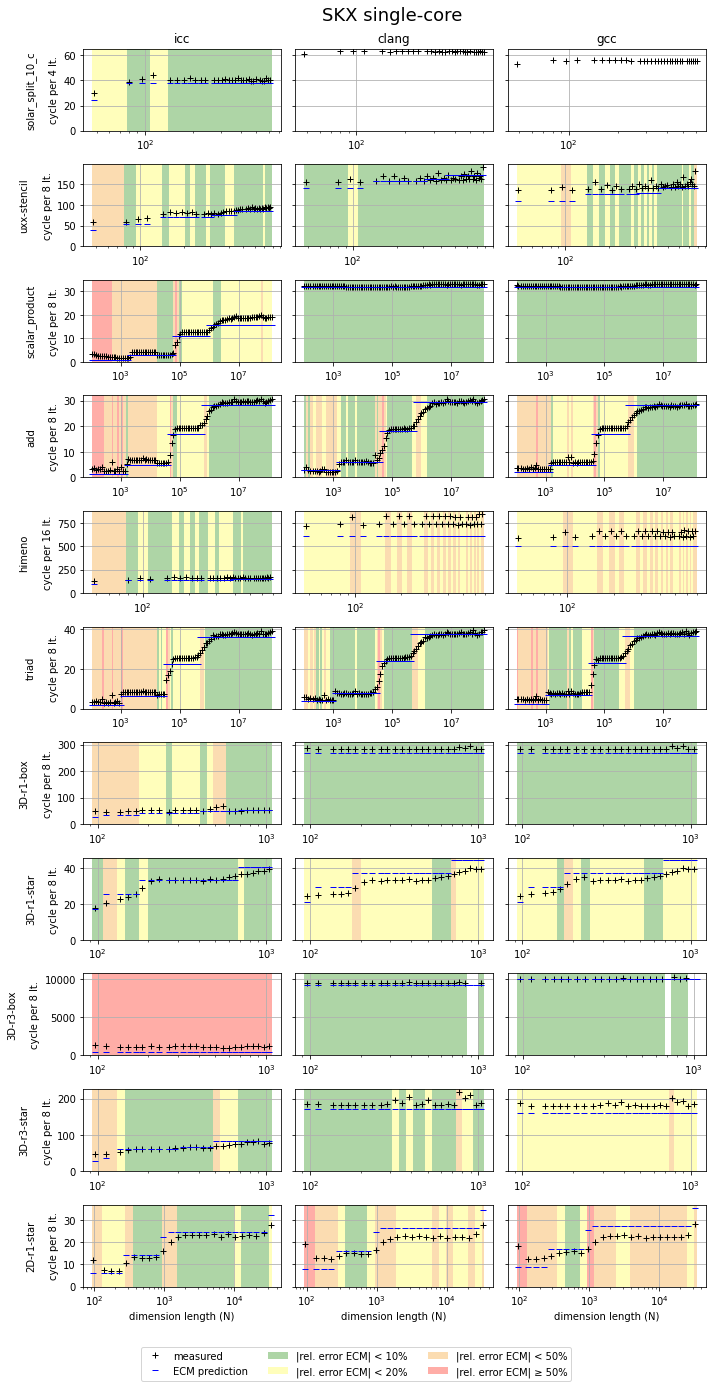

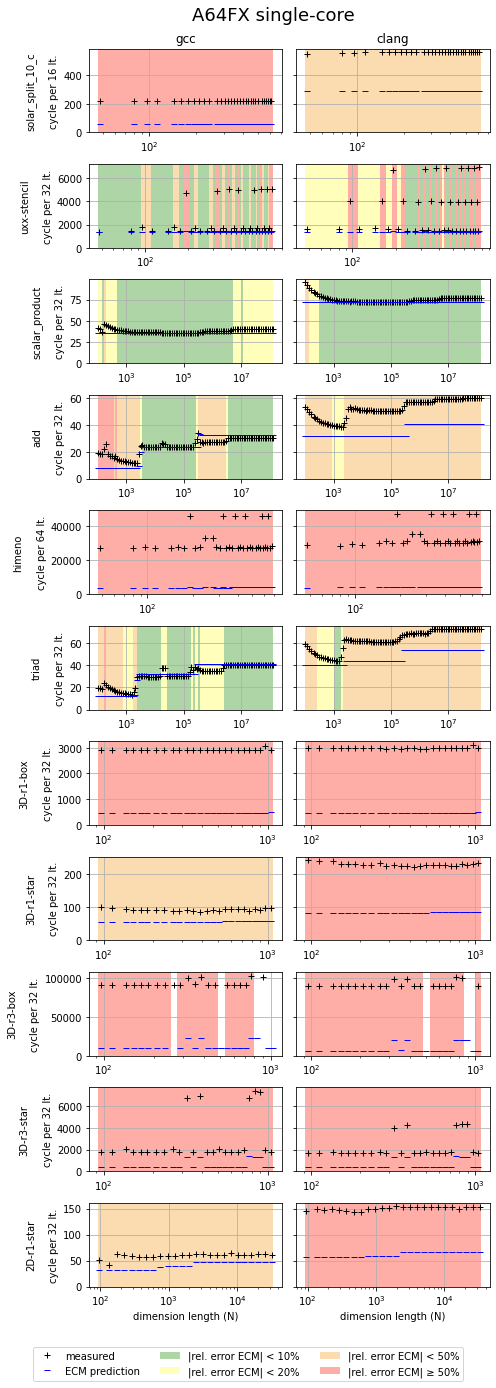

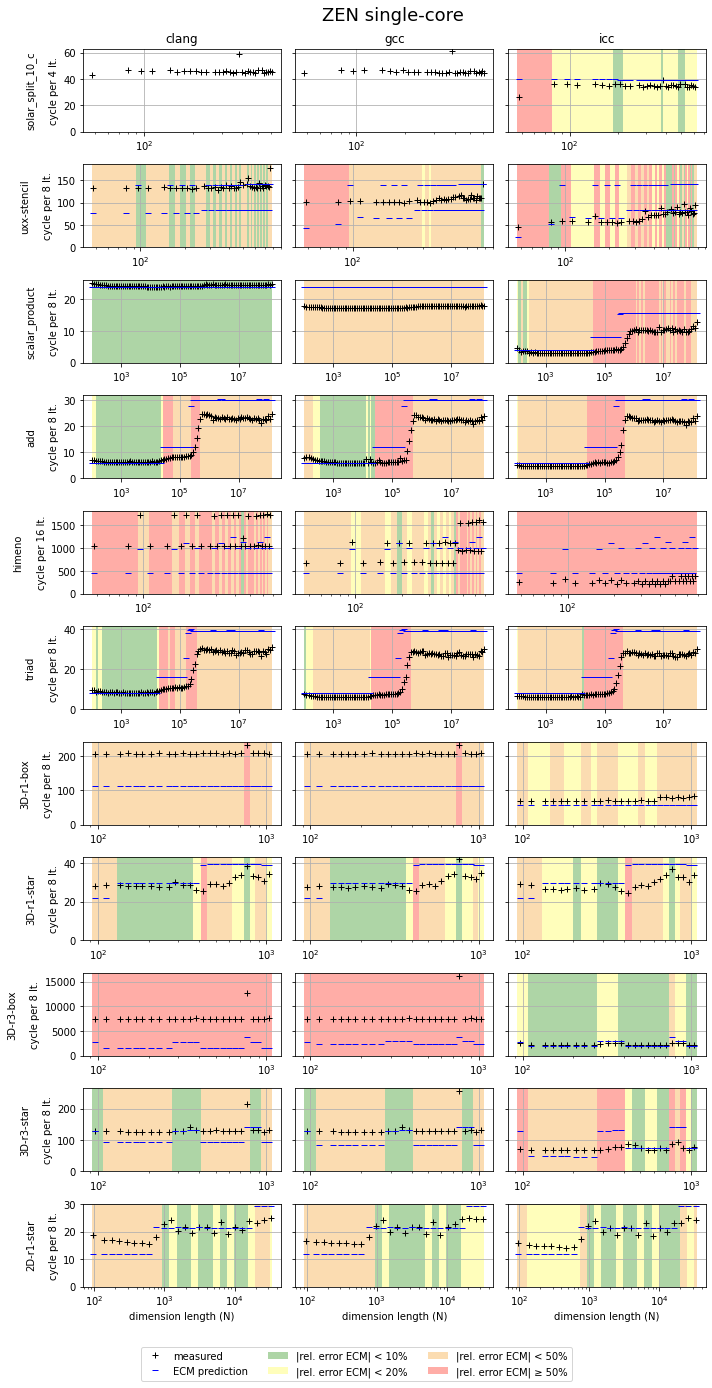

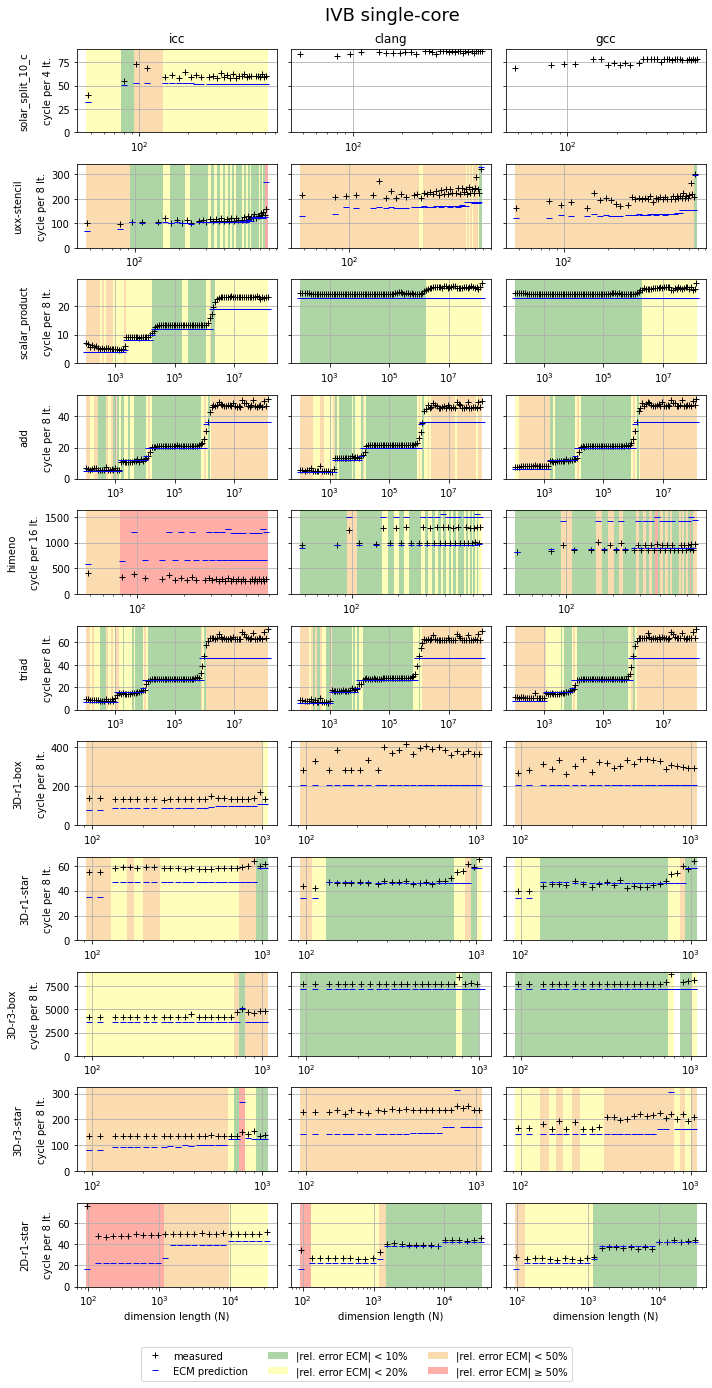

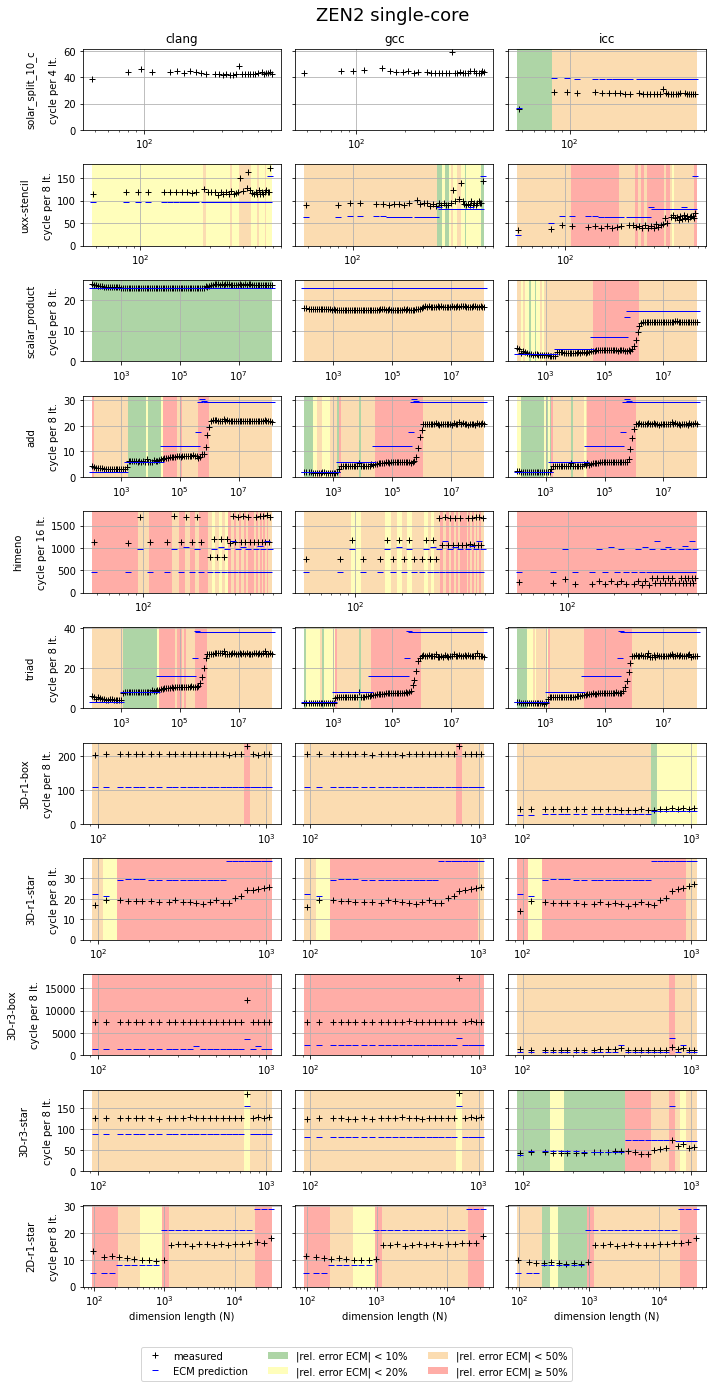

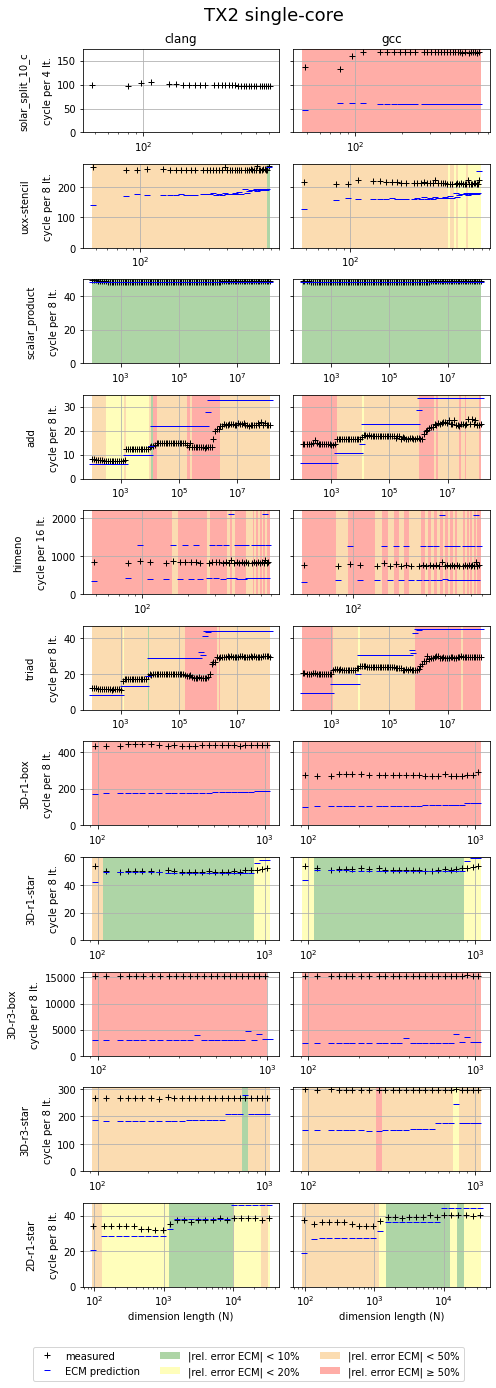

In [16]:
for a in analysis.arch.unique():
    plot_all_singlecore(a)

In [17]:
relerrcolors = {
    'green': (174/255, 213/255, 166/255, 1),
    'yellow': (255/255, 254/255, 187/255, 1),
    'orange': (251/255, 220/255, 177/255, 1),
    'red': (255/255, 173/255, 167/255, 1)
}
def multi_core_plots(cases, arrangement, legend=None, filename=None):
    assert len(cases) <= arrangement[0]*arrangement[1], \
        "More cases than spots in arrangement"
    fig, axs = plt.subplots(arrangement[1], arrangement[0],
                            figsize=(3*arrangement[0]+1, 2*arrangement[1]+0.5),
                            squeeze=False)
    
    xi, yi = -1, 0
    for kernel, arch, compiler in cases:
        kernel_orig = kernelname_map_r.get(kernel, kernel)
        xi += 1
        if xi >= arrangement[0]:
            yi += 1
            xi = 0
        ax = axs[yi,xi]
        
        d = analysis.query(
            "arch == @arch and kernel == @kernel_orig and compiler == @compiler and multicore"
        ).sort_values('cores')
        
        d.plot(
            x='cores',
            y=['measured', 'prediction_ECM'],
            ax=ax,
            style=['+', '_'],
            color=['black', 'blue'],
            grid=True,
            legend=False)
        ax.set_ylim(bottom=0)

        start = 0.5
        cur_region = None
        for idx, row in d.iterrows():
            if np.isnan(row.relative_error_ECM):
                new_region = None
            elif abs(row.relative_error_ECM) < 0.1:
                new_region = relerrcolors['green']
            elif abs(row.relative_error_ECM) < 0.2:
                new_region = relerrcolors['yellow']
            elif abs(row.relative_error_ECM) < 0.5:
                new_region = relerrcolors['orange']
            else:
                new_region = relerrcolors['red']
            if cur_region != new_region:
                new_start = row.cores - 0.5
                if cur_region is not None:
                    ax.axvspan(
                        start, new_start,
                        facecolor=cur_region)
                start = new_start
                cur_region = new_region
        if cur_region is not None:
            ax.axvspan(
                start, row.cores + 0.5,
                facecolor=cur_region)

        ax.set_title("{} with {} on {}".format(kernel, compiler, arch))
        ax.set_xlabel("cores")
        ax.set_ylabel("cycle per {:.0f} It.".format(d.iterations_per_cacheline.iloc[0]))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    for xi in range(xi + 1, arrangement[0]):
        axs[yi,xi].set_visible(False)
    
    if legend is not None:
        filler = []
        if legend.get('ncol', 0) == 2:
            filler = [plt.Rectangle((0,0), 0,0, alpha=0)]*2
        fig.legend(axs[0,0].lines + filler + [
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['green']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['yellow']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['orange']),
                       plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['red'])],
                   ['measured', 'ECM prediction'] + ['' for f in filler] + [
                    '|rel. error ECM| < 10%',
                    '|rel. error ECM| < 20%',
                    '|rel. error ECM| < 50%',
                    '|rel. error ECM| ≥ 50%'],
                   **legend)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

## Multi-Core Accuracy
The following five panels show well predicted multi-core and multi-NUMA-domain scaling:

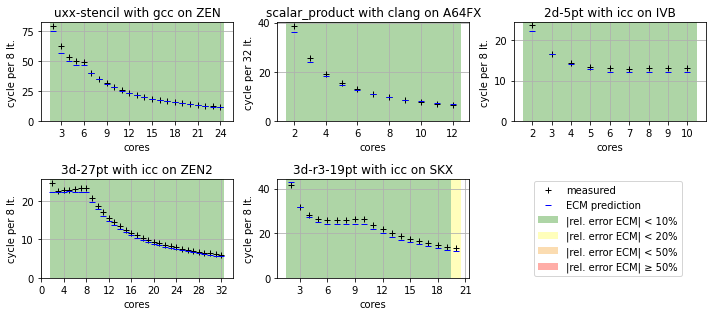

In [18]:
multi_core_plots([('uxx-stencil', 'ZEN', 'gcc'),
                    ('scalar_product', 'A64FX', 'clang'), 
                    ('2d-5pt', 'IVB', 'icc'), 
                    ('3d-27pt', 'ZEN2', 'icc'), 
                    ('3d-r3-19pt', 'SKX', 'icc')],
                  arrangement=(3, 2),
                  legend={'loc': 'center left', 'bbox_to_anchor': (.74, 0.28)},
                  filename='multi_core_good.pdf')

### In-Core Inaccuracies
In-core inaccuracy (discrapency already existed in single core prediction) can either decline, as seen in the first three plots, or persist, as in the last three plots, with increased core counts:

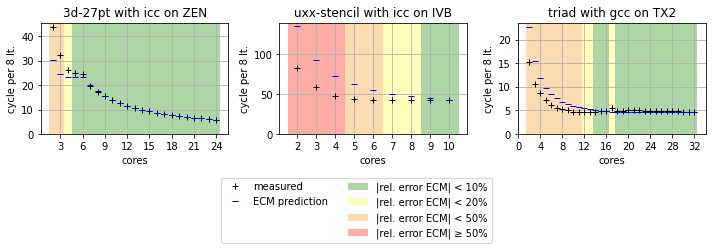

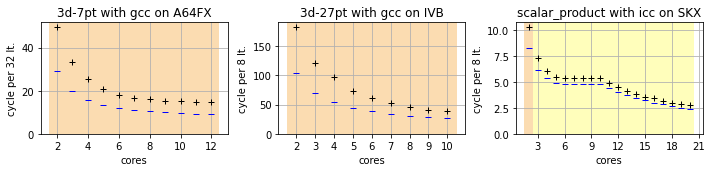

In [19]:
multi_core_plots([('3d-27pt', 'ZEN', 'icc'), ('uxx-stencil', 'IVB', 'icc'), ('triad', 'TX2', 'gcc')],
                  arrangement=(3, 1),
                  legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.4), 'ncol': 2},
                  filename='multi_core_in-core_declining.pdf')
multi_core_plots([('3d-7pt', 'A64FX', 'gcc'), ('3d-27pt', 'IVB', 'gcc'), ('scalar_product', 'SKX', 'icc')],
                  arrangement=(3, 1),
                  filename='multi_core_in-core_persisting.pdf')

### NUMA Saturation
Performance saturation may occure within a NUMA domain (first plot) or scale beyond one or multiple NUMA domains and saturate later (or never). The latter is seen in the second plot:

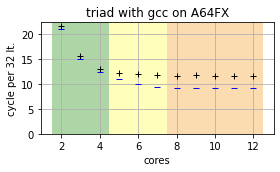

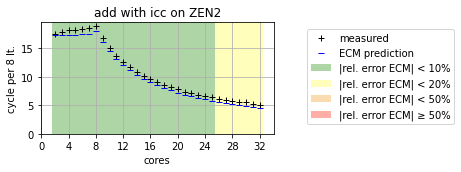

In [20]:
multi_core_plots([('triad', 'A64FX', 'gcc')],
                 arrangement=(1, 1),
                 legend=None,
                 filename='multi_core_saturation_in-NUMA.pdf')
multi_core_plots([('add', 'ZEN2', 'icc')],
                 arrangement=(1, 1),
                 legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                 filename='multi_core_saturation_beyond-NUMA.pdf')

### Multi-Core Scaling
While multi-core scaling may be intermittently inaccurate, these inaccuracy can be compensated by saturation effects:

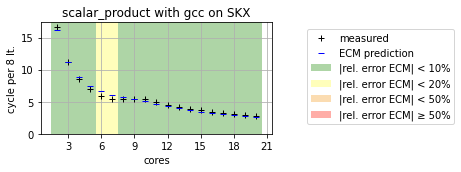

In [21]:
multi_core_plots([('scalar_product', 'SKX', 'gcc')],
                 arrangement=(1, 1),
                 legend={'loc': 'center left', 'bbox_to_anchor': (1.06, 0.55)},
                 filename='multi_core_scaling.pdf')

### Statistical Overview
Here is a small statical overview of all inaccuracies observed in the multi-core study:

In [22]:
err_analysis = analysis.groupby(["arch", "kernel", "compiler", "multicore"])[['relative_error_ECM', 'relative_error_RL']].describe()
best = {}
for e in [0.05, 0.1, 0.2, 0.3]:
    best[e] = {
        'overall': err_analysis[((err_analysis[('relative_error_ECM', 'max')] < e) &
                                 (err_analysis[('relative_error_ECM', 'min')] > -e))],
        'average': err_analysis[((err_analysis[('relative_error_ECM', 'mean')] < e) &
                                 (err_analysis[('relative_error_ECM', 'mean')] > -e))]
    }
    print(len(best[e]['overall']), "testcases with a maximum error of less than {:.0%}.".format(e))
    print(len(best[e]['average']), "testcases with an average error of less than {:.0%}.".format(e))
print(len(err_analysis), "total testcases")

11 testcases with a maximum error of less than 5%.
82 testcases with an average error of less than 5%.
35 testcases with a maximum error of less than 10%.
146 testcases with an average error of less than 10%.
93 testcases with a maximum error of less than 20%.
201 testcases with an average error of less than 20%.
143 testcases with a maximum error of less than 30%.
232 testcases with an average error of less than 30%.
352 total testcases


### Complete Multi-Core Anlaysis

In [23]:
relerrcolors = {
    'green': (174/255, 213/255, 166/255, 1),
    'yellow': (255/255, 254/255, 187/255, 1),
    'orange': (251/255, 220/255, 177/255, 1),
    'red': (255/255, 173/255, 167/255, 1)
}
def plot_all_multicore(arch):
    aarch = analysis.query('arch == @arch')
    fig, axs = plt.subplots(len(aarch.kernel.unique()), len(aarch.compiler.unique()),
                            figsize=(3*len(aarch.compiler.unique())+1, 1.6*len(aarch.kernel.unique())+1),
                            sharey='row',
                            sharex='all',
                            squeeze=False)

    for xi, c in enumerate(aarch.compiler.unique()):
        for yi, k in enumerate(aarch.kernel.unique()):
            kernelname = kernelname_map.get(k, k)
            ax = axs[yi,xi]

            d = aarch.query(
                "kernel == @k and compiler == @c and multicore"
            ).sort_values('cores')
        
            d.plot(
                x='cores',
                y=['measured', 'prediction_ECM'],
                ax=ax,
                style=['+', '_'],
                color=['black', 'blue'],
                grid=True,
                legend=False)
            if xi == len(aarch.compiler.unique())-1:
                ax.set_ylim(bottom=0)

            start = 0.5
            cur_region = None
            for idx, row in d.iterrows():
                if np.isnan(row.relative_error_ECM):
                    new_region = None
                elif abs(row.relative_error_ECM) < 0.1:
                    new_region = relerrcolors['green']
                elif abs(row.relative_error_ECM) < 0.2:
                    new_region = relerrcolors['yellow']
                elif abs(row.relative_error_ECM) < 0.5:
                    new_region = relerrcolors['orange']
                else:
                    new_region = relerrcolors['red']
                if cur_region != new_region:
                    new_start = row.cores - 0.5
                    if cur_region is not None:
                        ax.axvspan(
                            start, new_start,
                            facecolor=cur_region)
                    start = new_start
                    cur_region = new_region
            if cur_region is not None:
                ax.axvspan(
                    start, row.cores + 0.5,
                    facecolor=cur_region)

            if yi == 0:
                ax.set_title(c)
            if yi == len(aarch.kernel.unique())-1:
                ax.set_xlabel("cores")
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            else:
                ax.set_xlabel(None)
            if xi == 0:
                ax.set_ylabel(
                    "{}\n\ncycle per {:.0f} It.".format(k, d.iterations_per_cacheline.iloc[0]))

    fig.suptitle(arch+" multi-core", fontsize=18, y=.99, x=0.55)
    
    fig.legend(axs[0,0].lines + [
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['green']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['yellow']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['orange']),
                plt.Rectangle((0,0), 1, 1, facecolor=relerrcolors['red'])],
               ['measured', 'ECM prediction',
                '|rel. error ECM| < 10%',
                '|rel. error ECM| < 20%',
                '|rel. error ECM| < 50%',
                '|rel. error ECM| ≥ 50%'],
               ncol=3,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.04))
    fig.tight_layout()

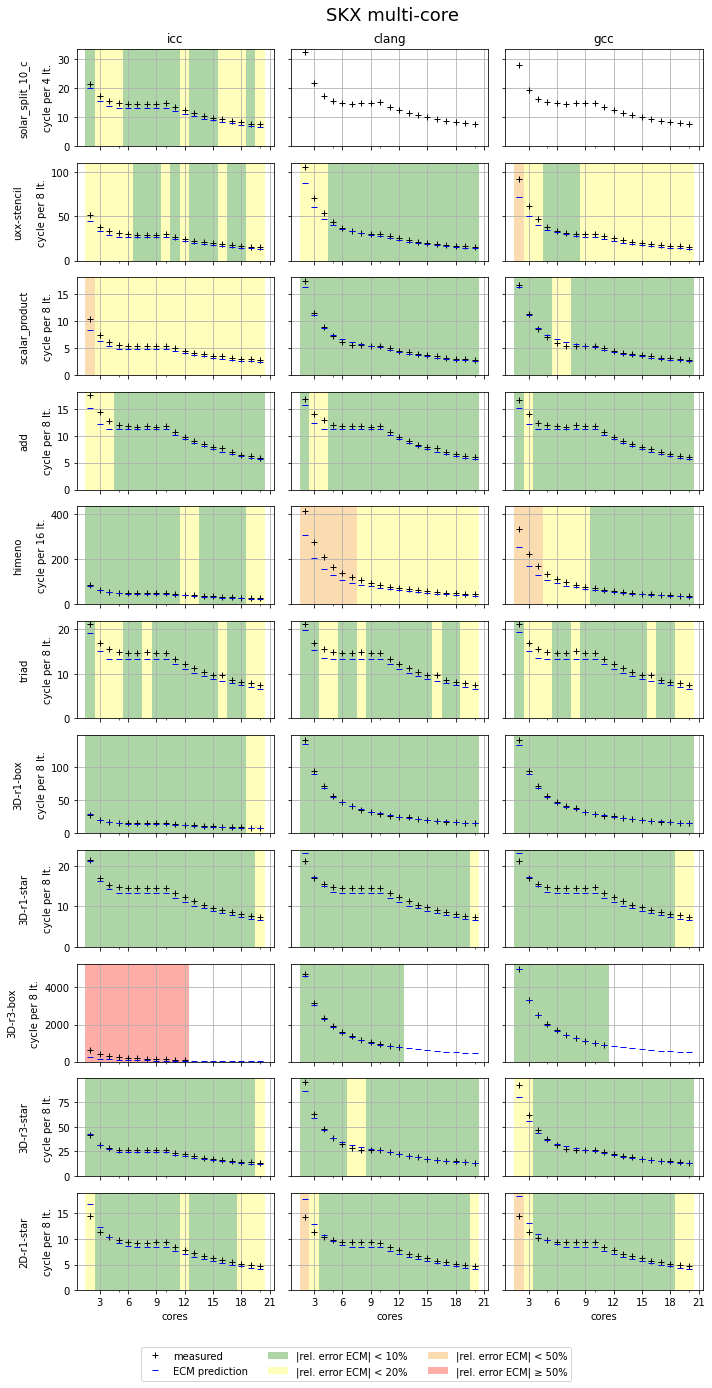

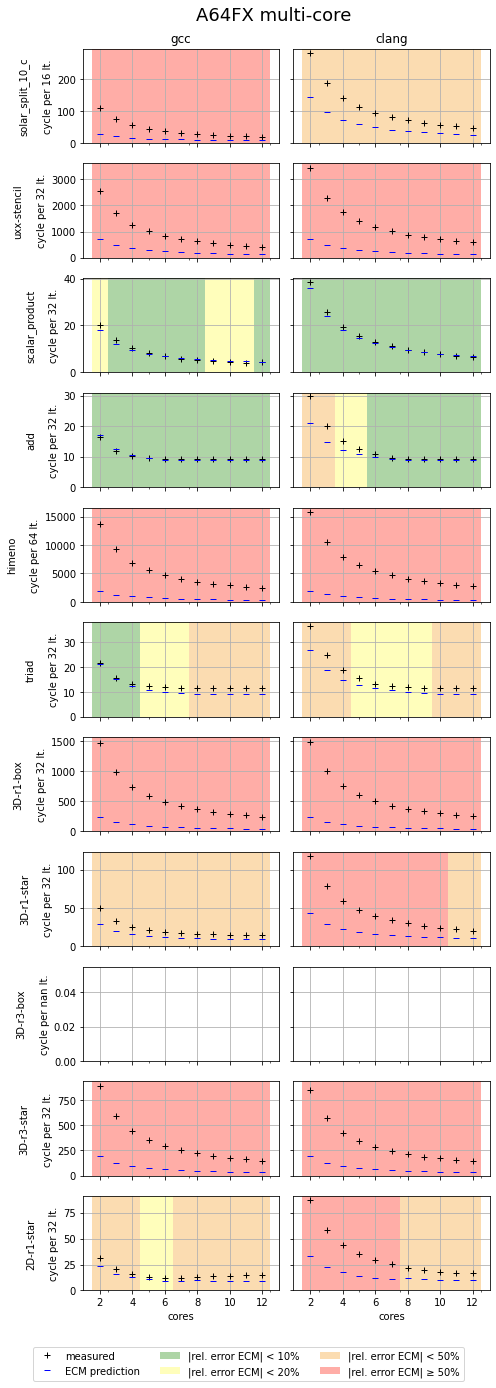

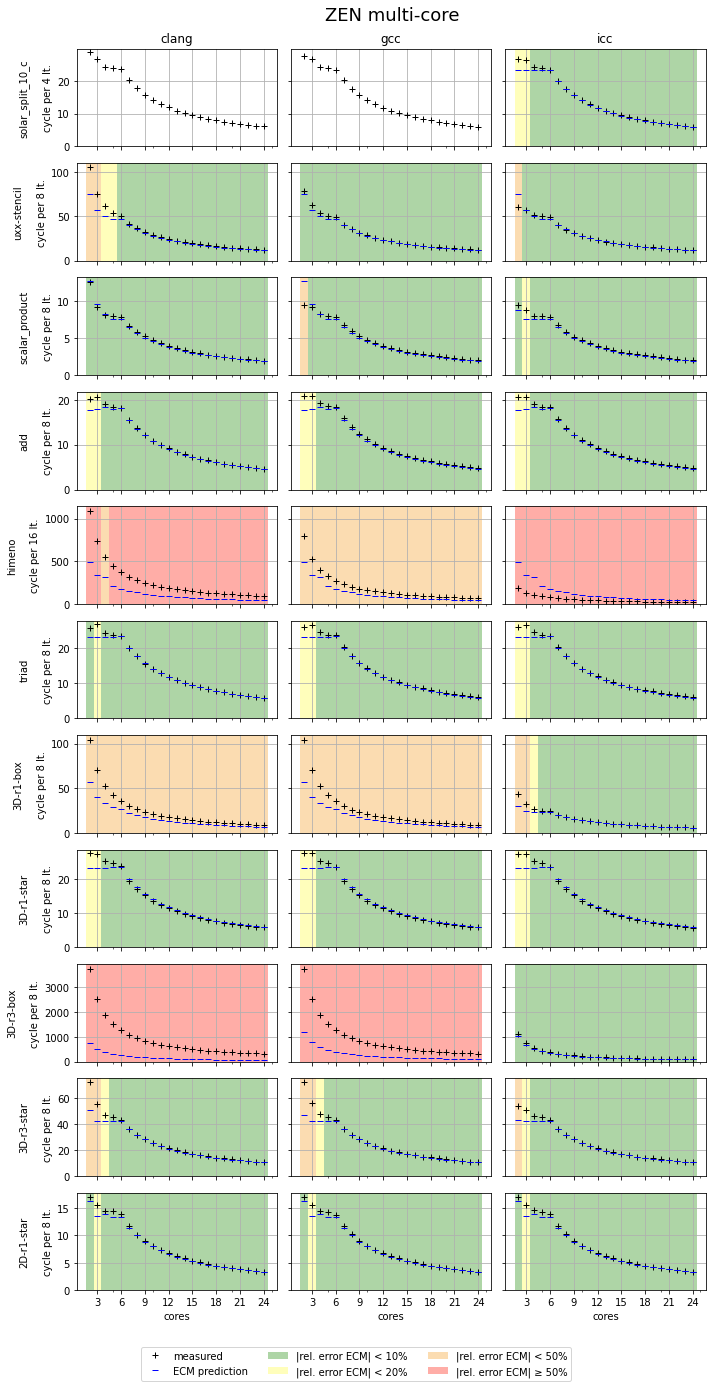

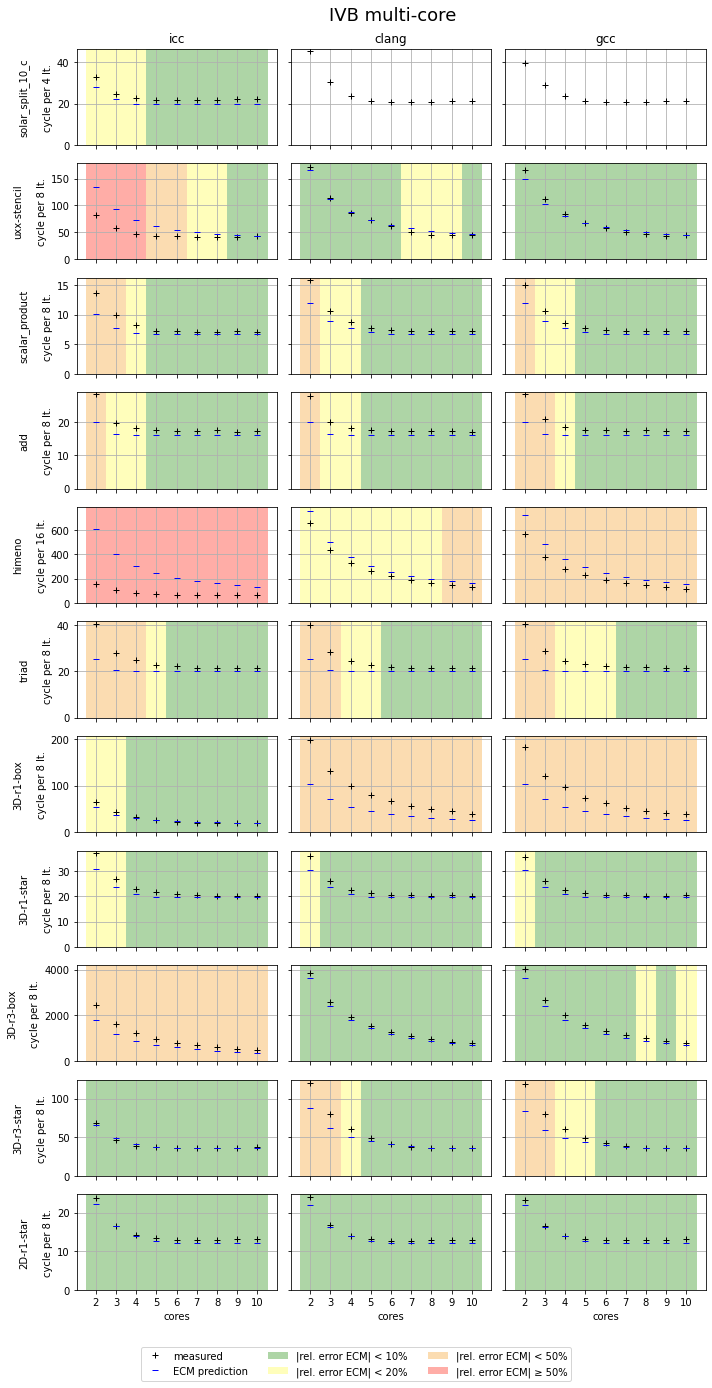

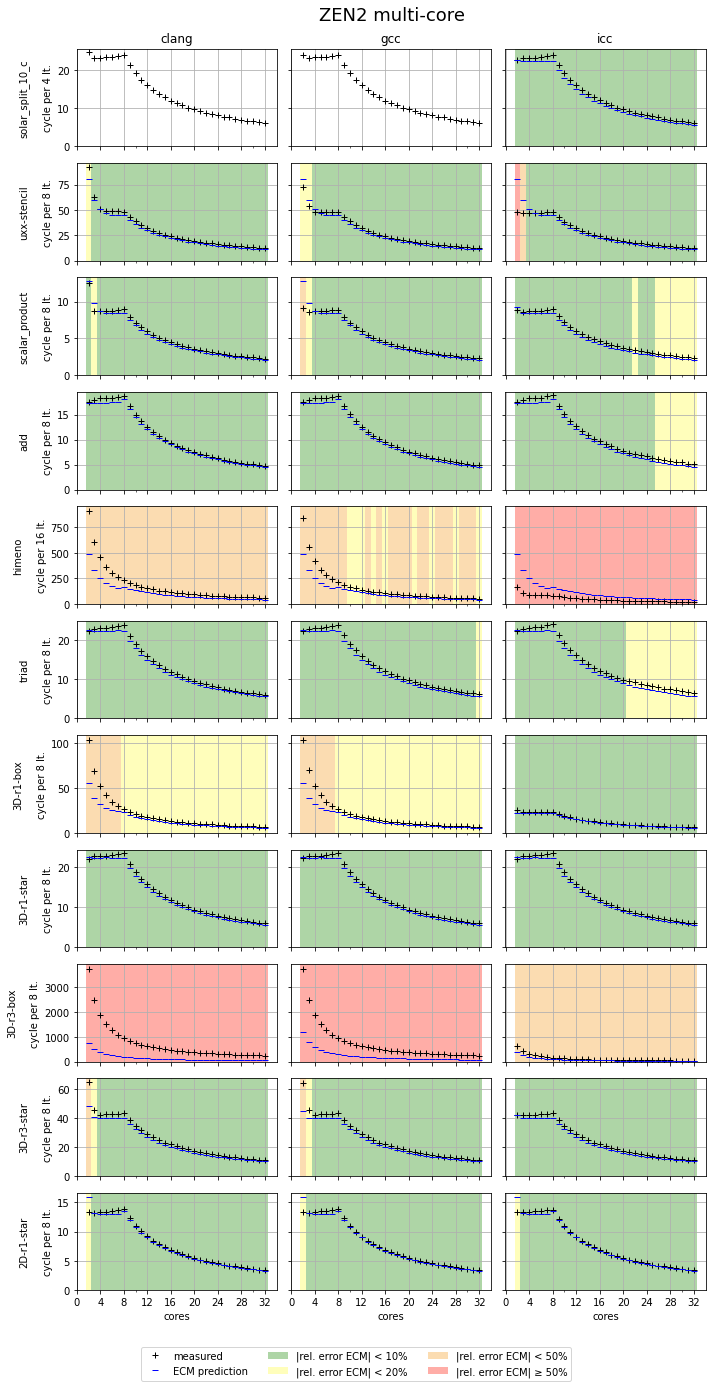

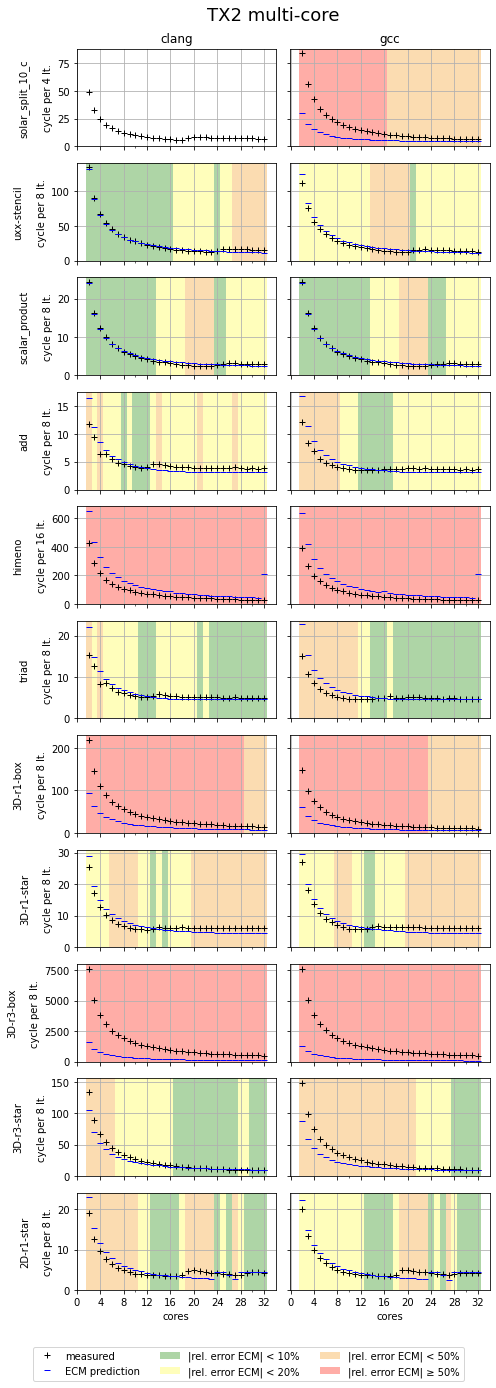

In [24]:
for a in analysis.arch.unique():
    plot_all_multicore(a)